In [1]:
import os
import random
import numpy as np
import tensorflow as tf
seed = 1
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
import gensim
import pandas as pd
import gensim.downloader as api
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import InputLayer, Dense, Embedding, LSTM, Dropout

In [4]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [5]:
def convert_to_sequence(questions):
    X = questions['Preprocessed_Question']
    cognitive_level = {"Knowledge": 0, "Comprehension": 1, "Application": 2, "Analysis": 3, "Synthesis": 4, "Evaluation": 5}
    questions["BT LEVEL"].replace(cognitive_level, inplace = True)
    y = questions['BT LEVEL'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.10, stratify = questions['BT LEVEL'], 
                                                         shuffle = True, random_state = 1)
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    tokenizer = Tokenizer(oov_token ='<OOV>')
    tokenizer.fit_on_texts(X_train)
    vocab = tokenizer.word_index
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    max_que_len = 500
    
    padded_X_train_seq = pad_sequences(X_train_seq, maxlen = max_que_len, padding = 'pre')
    padded_X_test_seq = pad_sequences(X_test_seq, maxlen = max_que_len, padding = 'pre')
    
    return padded_X_train_seq, y_train, padded_X_test_seq, y_test, vocab, max_que_len

In [6]:
def get_embedding(vocab):
    embedding_model = api.load('fasttext-wiki-news-subwords-300')
    embeddings = np.zeros((len(vocab) + 1, 300))
    for word, index in vocab.items():
        if word in embedding_model.key_to_index:
            embedding_vector = embedding_model[word]
            embeddings[index] = embedding_vector
        else:
            print(word)
    return embeddings

In [7]:
def build_model(vocab_size, embedding_len, max_que_len, embeddings):
  
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, output_dim = embedding_len, weights = [embeddings], 
                        input_length = max_que_len,  trainable = True))
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    model.add(Dense(6, activation ='softmax'))
    return model

In [8]:
def evaluate_model(model, X_test, y_test):
    pred = model.predict(X_test)
    predicted_classes = np.argmax(pred, axis = 1)
    true_classes = np.argmax(y_test, axis = 1)
    accuracy = accuracy_score(true_classes, predicted_classes)
    print(f"Accuracy: {accuracy}")
    f1_ = f1_score(true_classes, predicted_classes, average = 'weighted')
    print(f"F1 score: {f1_}")
    print(classification_report(true_classes, predicted_classes))

In [9]:
def plot_result(log_data): 
    plt.figure(figsize=(10, 6))
    plt.plot(log_data['loss'], label ='train')
    plt.plot(log_data['val_loss'], label ='test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.figure(figsize=(10, 6))
    plt.plot(log_data['accuracy'], label ='train')
    plt.plot(log_data['val_accuracy'], label ='test')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(log_data['f1_score'], label ='train')
    plt.plot(log_data['val_f1_score'], label ='test')
    plt.title('Model F1 Score')
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [10]:
questions = pd.read_excel('preprocessing_result/preprocessing_result-fasttext.xlsx')
questions

,Question,Preprocessed_Question,BT LEVEL
0,"Suppose prices of two goods are constant, expl...",suppose price good constant explain what happe...,Comprehension
1,Explain the concept of price leadership observ...,explain concept price leadership observe condi...,Comprehension
2,Define profit. Briefly explain how accounting ...,define profit briefly explain how account prof...,Comprehension
3,Describe the assumptions of monopolistic compe...,describe assumption monopolistic competitive m...,Comprehension
4,Explain the meaning of the law of diminishing ...,explain mean law diminish marginal return brie...,Comprehension
...,...,...,...
2517,PEST and SWOT are popular strategy tools. Disc...,pest swot popular strategy tool discuss how to...,Application
2518,List the advantages and disadvantages of Publi...,list advantage disadvantage public offer,Knowledge
2519,Show your calculations for all THREE (3) optio...,show calculation option discuss which option p...,Analysis
2520,Currently the product life cycle for Apple iPo...,currently product life cycle apple ipod growth...,Evaluation


In [11]:
padded_X_train_seq, y_train, padded_X_test_seq, y_test, vocab, max_que_len = convert_to_sequence(questions)

In [12]:
embeddings_fasttext = get_embedding(vocab)
np.save('embedding/fasttext/embeddings.npy', embeddings_fasttext)

In [13]:
embeddings_fasttext = np.load('embedding/fasttext/embeddings.npy')

In [14]:
training_logger = CSVLogger('log/FastText/training.log', separator = ',', append = False)

In [15]:
#model
model = build_model(len(vocab) + 1, 300, max_que_len, embeddings_fasttext)
# compiling the model
model.compile(optimizer = 'RMSprop', loss='categorical_crossentropy', metrics= ['accuracy', tfa.metrics.F1Score(6, 'weighted')])
# printing summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          1114200   
                                                                 
 lstm (LSTM)                 (None, 32)                42624     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
Total params: 1,157,022
Trainable params: 1,157,022
Non-trainable params: 0
_________________________________________________________________


In [16]:
# fit the model
model.fit(padded_X_train_seq, y_train, epochs = 50, batch_size = 16, validation_data = (padded_X_test_seq, y_test),
                                                                      callbacks = [training_logger], verbose = 1)

Epoch 1/50
142/142 [==============================] - 43s 271ms/step - loss: 1.4692 - accuracy: 0.4328 - f1_score: 0.3199 - val_loss: 1.1965 - val_accuracy: 0.5850 - val_f1_score: 0.5103
Epoch 2/50
142/142 [==============================] - 38s 265ms/step - loss: 0.8282 - accuracy: 0.7435 - f1_score: 0.7254 - val_loss: 0.8940 - val_accuracy: 0.7352 - val_f1_score: 0.7355
Epoch 3/50
142/142 [==============================] - 36s 257ms/step - loss: 0.4450 - accuracy: 0.8766 - f1_score: 0.8763 - val_loss: 0.7465 - val_accuracy: 0.8024 - val_f1_score: 0.7999
Epoch 4/50
142/142 [==============================] - 37s 261ms/step - loss: 0.2661 - accuracy: 0.9286 - f1_score: 0.9285 - val_loss: 0.7802 - val_accuracy: 0.7708 - val_f1_score: 0.7753
Epoch 5/50
142/142 [==============================] - 34s 241ms/step - loss: 0.1726 - accuracy: 0.9542 - f1_score: 0.9542 - val_loss: 0.8036 - val_accuracy: 0.7668 - val_f1_score: 0.7674
Epoch 6/50
142/142 [==============================] - 35s 250ms/s

In [17]:
log_data = pd.read_csv('log/FastText/training.log', sep = ',', engine = 'python')
log_data.head(50)

,epoch,accuracy,f1_score,loss,val_accuracy,val_f1_score,val_loss
0,0,0.432790,0.319931,1.469237e+00,0.584980,0.510293,1.196475
1,1,0.743499,0.725436,8.282368e-01,0.735178,0.735541,0.893960
2,2,0.876598,0.876267,4.449877e-01,0.802372,0.799912,0.746472
3,3,0.928603,0.928493,2.660897e-01,0.770751,0.775283,0.780235
4,4,0.954165,0.954213,1.725771e-01,0.766798,0.767436,0.803627
5,5,0.965183,0.965210,1.225173e-01,0.774704,0.772550,0.843950
6,6,0.977082,0.977083,8.763727e-02,0.762846,0.759041,0.940489
7,7,0.985456,0.985466,5.471576e-02,0.758893,0.756307,1.098521
8,8,0.984575,0.984576,5.281654e-02,0.758893,0.758289,1.006010
9,9,0.991186,0.991183,3.524485e-02,0.747036,0.746856,1.102324


In [18]:
log_data['val_accuracy'].describe()

count    50.000000
mean      0.724032
std       0.030790
min       0.584980
25%       0.711462
50%       0.723320
75%       0.735178
max       0.802372
Name: val_accuracy, dtype: float64

In [19]:
log_data['val_f1_score'].describe()

count    50.000000
mean      0.721722
std       0.038476
min       0.510293
25%       0.710766
50%       0.722446
75%       0.734453
max       0.799912
Name: val_f1_score, dtype: float64

In [20]:
log_data[['val_accuracy']].idxmax() + 1

val_accuracy    3
dtype: int64

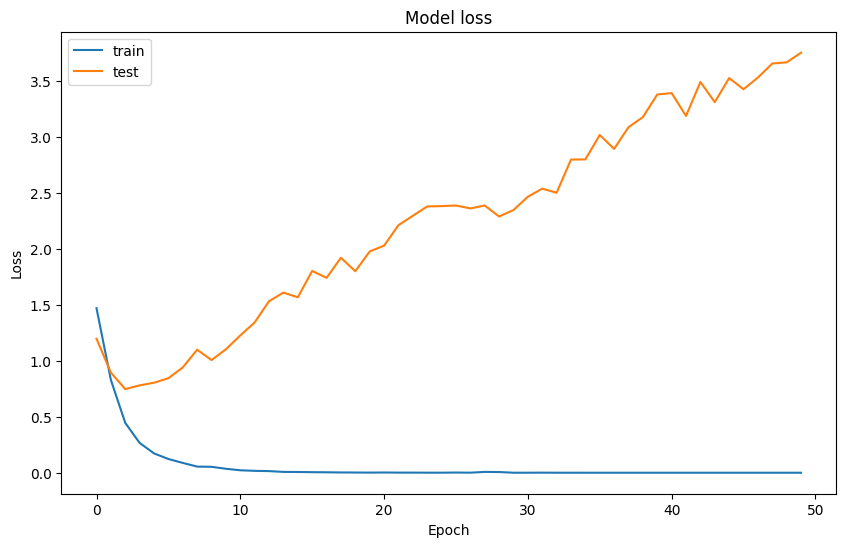

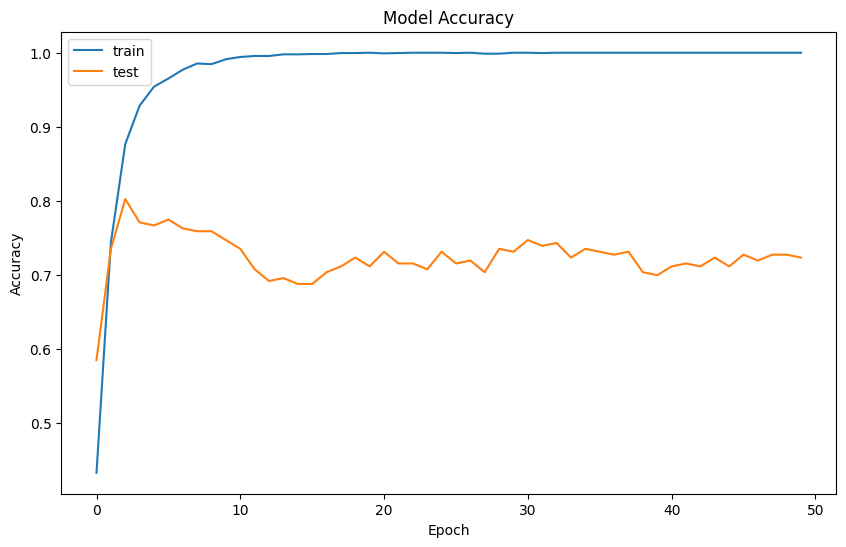

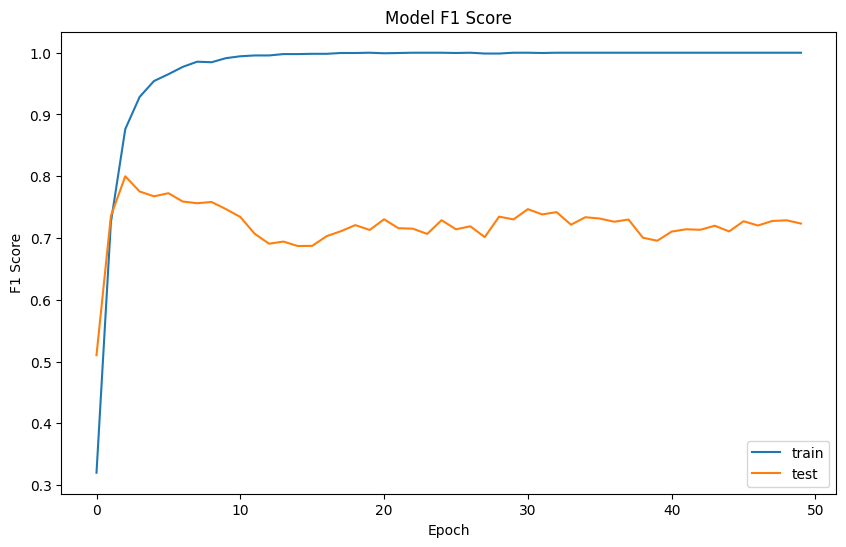

In [21]:
plot_result(log_data)